In [1]:
import seispy.utils.responses as rsps
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from seispy import plot as hplot
from seispy.station import homestake, spiral
from seispy.station.stationdata import SeismometerArray
from scipy.linalg import pinv, svd
import warnings
warnings.filterwarnings(action='once')

# Comparison of Beamforming methods and radiometer

Here I compare several beamforming methods where instead of using the steering vector $a$ that is often discussed, we use a response matrix that projects the phase **and** accounts for the direction of the measurement channel and the polarization of the wave under consideration.

I have done this assuming a specific velocity, for simplicity's sake. However, one could just as easily include velocities as well. 

# Preliminaries

Set some ground rules:

P-waves at 5.7 km/s
R-waves at 2.5 km/s
One each.

In [2]:
duration=1000
freq=1
velocity=5700
amplitude=1
nside=8
stations = spiral(50, radius=5000, n_per_turn=20)
# stations=homestake(origin='TPK')
from seispy.station import StationArray
data = SeismometerArray.initialize_all_good(stations, duration, chans_type='fast_chans')
data.add_p_wave(amplitude, np.radians(30), np.radians(60), freq, duration, c=velocity)
data.add_r_wave(amplitude, np.radians(-60), np.radians(90), freq, duration)
# data.add_white_noise(1)

	using default eigenfunction


# Calculate response matrices

Dimension is (2 * Ndirections x 3 * Nseismometers). Think of these like the polarization-equivalent of the steering vector in beamforming.

See definition here: https://www.overleaf.com/read/bsryynnjpqzv

In [3]:
responseP, j1, j2, j3 = data.get_response_matrix_healpy('p', stations, freq, velocity, nside=nside)
responseR, j1, j2, j3 = data.get_response_matrix_healpy('r', stations, freq, 2504, nside=nside)
response = np.vstack((responseP, responseR))

# Calculate coherences

$\bf{R}_{xx}$ is the coherence matrix. `cohs` is a vector of coherences to be used for the "power" radiometer later that uses cross-correlations explicitly. `myffts` will be used by the phase-coherent radiometer.

In [4]:
myffts = np.zeros((response.shape[1], 1), dtype=complex)

counter = 0
for station in data.keys():
    for chan in ['HHE', 'HHN','HHZ']:
        tmpdata = data[station][chan].copy()
        myffts[counter] = (2 * np.sum(tmpdata.value * np.exp(-2 * np.pi * 1j * freq * tmpdata.times.value)) / tmpdata.size)
        counter += 1
# cross-correlation matrix
Rxx = np.zeros((counter, counter), dtype='complex')
for ii in range(counter):
    for jj in range(counter):
        Rxx[ii, jj] = np.conj(myffts[ii]) * myffts[jj]
Ndets = Rxx.shape[0]
Npairs = (Ndets**2 + Ndets) / 2.
cohs = data.get_coherences(freq)

# Bartlett Beamformer with polarizations

We use the response matrices calculated for the directions we've chosen. Each row of the response corresponds to a "steering" vector. We do not account for correlations between directions due to detector geometry (which we will do later).

$$ P(\hat\Omega) = \frac{\mathcal R_{\hat\Omega, \rm{detectors}}^{\dagger} \bf{R}_{xx} \mathcal R_{\hat\Omega, \rm{detectors}}}{\mathcal R_{\hat\Omega, \rm{detectors}}^{\dagger}\mathcal R_{\hat\Omega, \rm{detectors}}}$$

We note that $\mathcal R_{\hat\Omega, \rm{detectors}}^{\dagger}$ is a *vector* here. We are picking out a single row from the full response matrix. Therefore the denominator is a *scalar*. No matrix inversions are done. We run a loop over $\hat\Omega$'s for all directions

In [5]:
Npix = 2 * hp.nside2npix(nside)
recovery = np.zeros(Npix, dtype='complex')
for ii in range(Npix):
    recovery[ii] = np.dot(np.dot(response[ii, :], Rxx), response[ii, :].T) / np.dot(response[ii, :], response[ii, :].T)
print(recovery.shape)

(1536,)


/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (66) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3

/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (40) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (80) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (41) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))


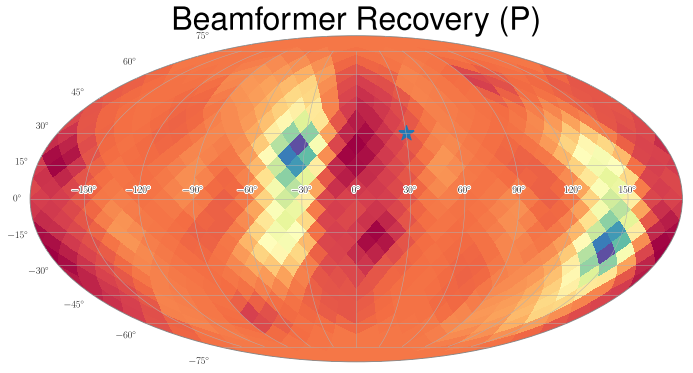

/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (66) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (101) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pme

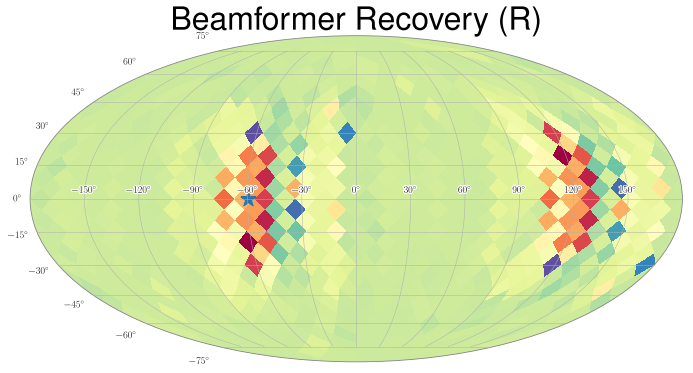

In [6]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection='mollweide')
hplot.healpix_heatmap(np.real(recovery[:int(Npix/2)]), cmap='Spectral_r')#, vmin=0, vmax=np.abs(np.real(recovery)).max())
plt.title("Beamformer Recovery (P)", fontsize=32)
hplot.outline_text(ax)
ax.scatter(np.radians(30), np.radians(30), marker='*', s=256, color='C0')
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.show()

plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection='mollweide')
hplot.healpix_heatmap(np.real(recovery[int(Npix/2):]), cmap='Spectral_r')#, vmin=0, vmax=np.abs(np.real(recovery)).max())
plt.title("Beamformer Recovery (R)", fontsize=32)
hplot.outline_text(ax)
ax.scatter(np.radians(-60), np.radians(0), marker='*', s=256, color='C0')
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.show()

# MUSIC with polarization (Radio-MUSIC)

The MUSIC algorithm asks that we take the "noise subspace" of the coherence matrix ${\bf R}_{xx}$ and we create an orthogonal projection to that subspace. This is done by taking a singular-value decomposition of the coherence matrix and creating a projection where we remove the eigenvectors consistent with the largest eigenvalues (i.e. the "signal" subspace"). 

$$ {\bf R}_{xx} = U\Sigma U^\dagger = U_N \Sigma_N U_N^\dagger + U_S \Sigma_S U_S^\dagger.$$ From here we create a projection operator $\Pi_N = U_N U_N^\dagger$ and the normalized power in each direction is given by:

$$ P(\hat\Omega) = \frac{\mathcal R_{\hat\Omega, \rm{detectors}}^{\dagger} \mathcal R_{\hat\Omega, \rm{detectors}}}{\mathcal R_{\hat\Omega, \rm{detectors}}^{\dagger} \Pi_N \Pi_N^\dagger \mathcal R_{\hat\Omega, \rm{detectors}}}$$

Again, this is done where we loop over *vectors* so again the denominator is a *scalar*

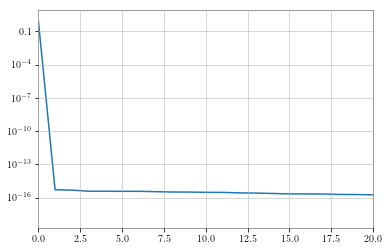

(150, 150)
(150, 150)


In [7]:
# Music man
u, s, vh = svd(Rxx)
plt.plot(s / max(s))
# plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 20)
plt.show()

print(u.shape)
print(vh.shape)

In [8]:
Un = u.copy()
proj = np.dot(u[:, 5:], u[:, 5:].T.conj())
Npix = hp.nside2npix(nside)
recovery = np.zeros(2*Npix, dtype='complex')
for ii in range(2*Npix):
    mat = np.dot(response[ii, :], proj)
    recovery[ii] = np.dot(response[ii, :], response[ii, :].T.conj()) / np.dot(mat, mat.T.conj())
print(recovery.shape)

(1536,)


/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (82) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (97) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmey

/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (85) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (73) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (67) of font (/us

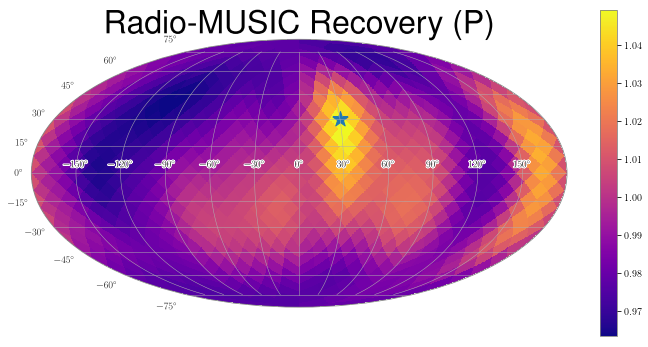

/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (82) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (97) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmey

/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (73) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (67) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (101) of font (/u

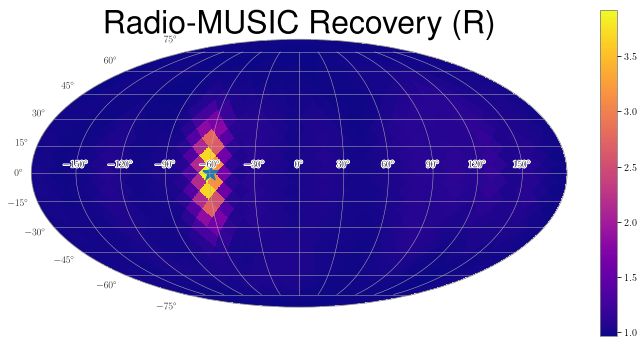

In [9]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection='mollweide')
hplot.healpix_heatmap(np.abs(recovery[:int(Npix)]) / np.median(np.real(recovery)), cmap='plasma')
plt.title("Radio-MUSIC Recovery (P)", fontsize=32)
hplot.outline_text(ax)
ax.scatter(np.radians(30), np.radians(30), marker='*', s=256, color='C0')
plt.colorbar()
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.show()

plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection='mollweide')
hplot.healpix_heatmap(np.abs(recovery[int(Npix):]) / np.median(np.abs(recovery)), cmap='plasma')
plt.title("Radio-MUSIC Recovery (R)", fontsize=32)
hplot.outline_text(ax)
ax.scatter(np.radians(-60), np.radians(0), marker='*', s=256, color='C0')
plt.colorbar()
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.show()

# New Radio-MUSIC

In this case, instead of taking vectors we use full matrices for the responses. This causes problems because what was the "denominator" before is now a matrix that must be inverted and that matrix is singular...meaning we need to create a pseudo-inverse. In the end, this appears not to have worked all that well. The formula, though, expressing what's going on, is given by:

$$ P = \rm{diag}\left(\left[\mathcal R_{\hat\Omega, \rm{detectors}}^{\dagger} \Pi_N \Pi_N^\dagger \mathcal R_{\hat\Omega, \rm{detectors}}\right]^{-1}\mathcal R_{\hat\Omega, \rm{detectors}}^{\dagger} \mathcal R_{\hat\Omega, \rm{detectors}}\right)$$

where now $\mathcal R_{\hat\Omega, \rm{detectors}}$ this is our full response **matrix** (i.e. we don't loop over columns...we do this all at once). 

In [10]:
mat = np.dot(response, proj)
denom = np.dot(mat, mat.T.conj())
denom_inv = pinv(denom, cond=1e-2)
recovery = np.diag(np.dot(denom_inv, np.dot(response, response.T.conj())))

/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (82) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (97) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmey

/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (85) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (73) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (67) of font (/us

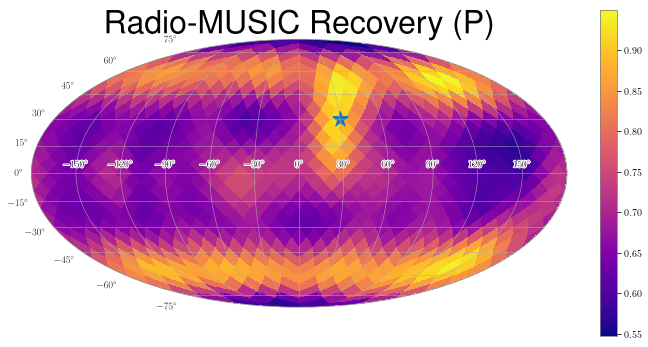

/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (82) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (97) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmey

/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (67) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (101) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (99) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (118) of font (/

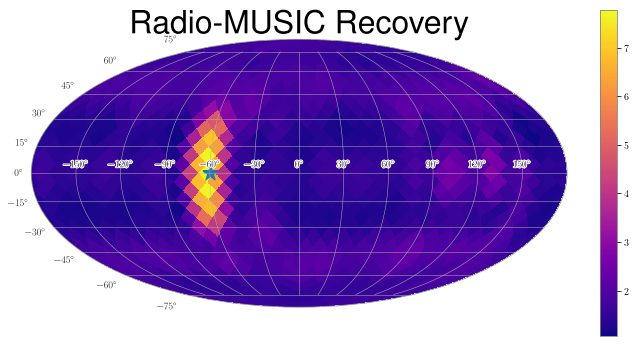

In [11]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection='mollweide')
hplot.healpix_heatmap(np.abs(recovery[:int(Npix)]) / np.median(np.real(recovery)), cmap='plasma')
plt.title("Radio-MUSIC Recovery (P)", fontsize=32)
hplot.outline_text(ax)
ax.scatter(np.radians(30), np.radians(30), marker='*', s=256, color='C0')
plt.colorbar()
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.show()

plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection='mollweide')
hplot.healpix_heatmap(np.abs(recovery[int(Npix):]) / np.median(np.abs(recovery)), cmap='plasma')
plt.title("Radio-MUSIC Recovery", fontsize=32)
hplot.outline_text(ax)
ax.scatter(np.radians(-60), np.radians(0), marker='*', s=256, color='C0')
plt.colorbar()
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.show()

# Phase Coherent Radiometer

In this method we construct an estimator for the fourier transform at each sensor. See the radiometer notes linked above for details.

In theory we can recover the both the *amplitude* and *phase* of the passing seismic wave.

(1536,)


/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (82) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (97) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmey

/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (121) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (40) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (80) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (41) of font (/u

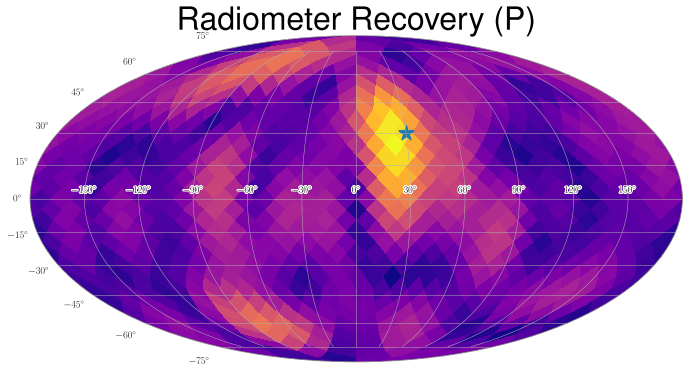

/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (82) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (97) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmey

/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (40) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/Users/pmeyers/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (41) of font (/usr/local/texlive/2018/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))


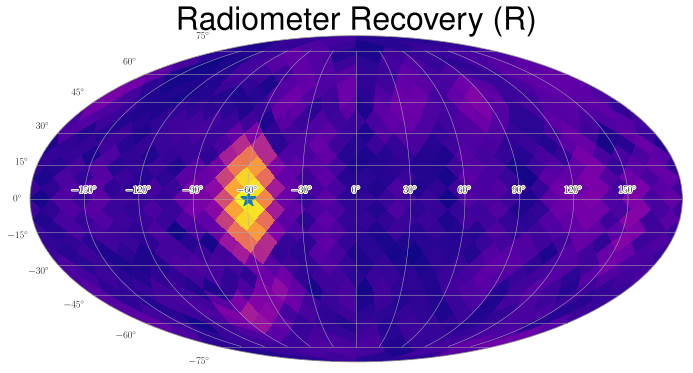

In [12]:
Fisher = np.dot(response.conj(), response.T)
InvFisher = pinv(Fisher, cond=1e-2)
recovery = np.dot(InvFisher, np.dot(response.conj(), myffts)).squeeze()
print(recovery.shape)
plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection='mollweide')
hplot.healpix_heatmap(np.abs(recovery[:int(Npix)]), cmap='plasma', vmin=0, vmax=np.abs(recovery[:int(Npix)]).max())
plt.title("Radiometer Recovery (P)", fontsize=32)
hplot.outline_text(ax)
ax.scatter(np.radians(30), np.radians(30), marker='*', s=256, color='C0')
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.show()


plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection='mollweide')
hplot.healpix_heatmap(np.abs(recovery[int(Npix):]), cmap='plasma', vmin=0, vmax=np.abs(recovery[int(Npix):]).max())
plt.title("Radiometer Recovery (R)", fontsize=32)
hplot.outline_text(ax)
ax.scatter(np.radians(-60), np.radians(0), marker='*', s=256, color='C0')
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.show()

# Traditional radiometer

In this method, we attempt to construct a model for the *cross-correlations* between all of our stations and then solve a maximum likelihood problem. This is (or soon will be) discussed in the radiometer notes above, but the general idea is that, for simplicity, we consider a vector of cross-correlations $Y$ (essentially a flattened version of the upper-triangular part of ${\bf R}_{xx}$. Based on our array geometry we construct some response matrices for how the cross-correlations respond to a passing wave of a specific **power** and polarization. In this sense, the problem is similar to the phase coherent radiometer above in terms of the details of the solution.

We still solve a maximum likelihood problem, but instead of using the Fourier transforms of the individual detector resopnses, we use the cross-correlations and their "responses" (which we often call the "Overlap reduction functions")

**In the end, the overlap reduction functions are essentially flattened versions of the product of the response matrices discussed before. This will be useful in considering a comaprison between this and the "full" bartlett beamformer discussed below.**

In this case the solution is:

$$ P = \left[G^\dagger G\right]^{-1} G^\dagger Y$$ where, again $G$ can be thought of as being related to $\mathcal R^\dagger \mathcal R$. 

In [14]:
# calculate overlap reduction functions
Gp, j1 = data.get_gamma_matrix_healpy('p', stations, velocity, freq, nside=nside)
Gr, j1 = data.get_gamma_matrix_healpy('r', stations, 2504, freq, nside=nside)
G = np.vstack((Gp, Gr)).T

KeyboardInterrupt: 

In [ ]:
Fisher = np.dot(G.T.conj(), G)

In [ ]:
u, s, vh = svd(Fisher)
plt.plot(np.arange(1, s.size+1), s / max(s))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
InvFisher = pinv(Fisher, cond=1e-2)
recovery = np.dot(np.real(InvFisher), np.real(np.dot(G.T.conj(), cohs))).squeeze()
print(recovery.shape)
print(recovery.real.std())
print(recovery.real.mean())

In [ ]:
recmax = np.abs(np.real(recovery)).max()
plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection='mollweide')
hplot.healpix_heatmap(np.real(recovery[:int(Npix)]), cmap='Spectral_r', vmin=-recmax, vmax=recmax)#, vmin=0, vmax=np.abs(recovery).max())
plt.title("Power Radiometer Recovery (P)", fontsize=32)
hplot.outline_text(ax)
ax.scatter(np.radians(30), np.radians(30), marker='*', s=256, color='C0')
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.show()


plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection='mollweide')
hplot.healpix_heatmap(np.real(recovery[int(Npix):]), cmap='Spectral_r', vmin=-recmax, vmax=recmax)#, vmin=0, vmax=np.abs(recovery).max())
plt.title("Power Radiometer Recovery (R)", fontsize=32)
hplot.outline_text(ax)
ax.scatter(np.radians(-60), np.radians(0), marker='*', s=256, color='C0')
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.show()

# Proper beamformer

In this case, instead of considering individual directions and looping over them, like we did in the first barlett beamformer, we consdier all directions together. In this case, our solution ends up being:

$$P(\hat\Omega) = \rm{diag}\left(\left[\mathcal R_{\hat\Omega, \rm{detectors}}^{\dagger}\mathcal R_{\hat\Omega, \rm{detectors}}\right]^{-1} \mathcal R_{\hat\Omega, \rm{detectors}}^{\dagger} {\bf R}_{xx} \mathcal R_{\hat\Omega, \rm{detectors}}\right)$$

where now the curly R's are full matrices instead of looping over vectors. One would do this to try remove any known correlations between pixels due to our array geometry. In GW terms we are creating a "clean" map.

As you'll see from the radiometer notes, this bears a *striking* resemblance to the radiometer. It is almost identical. 

As usual the matrix we are trying to invert is singular, so we must create a pseudo-inverse. In the end this produces results very similar to the radiometer.

In [ ]:
new_matrix = np.dot(np.dot(response.conj(), Rxx.conj()), response.T)
Fisher = np.dot(response.conj(), response.T)
InvFisher = pinv(Fisher, 1e-3)
recovery = np.diag(np.dot(InvFisher, new_matrix))

In [ ]:
print(recovery.shape)

In [ ]:
print(np.abs(recovery).max())

In [ ]:
recmax = np.abs(recovery).max()
plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection='mollweide')
hplot.healpix_heatmap(np.real(recovery[:int(Npix)]), cmap='Spectral_r', vmin=-recmax, vmax=recmax)#, vmin=0, vmax=np.abs(recovery).max())
plt.title("Power Radiometer Recovery (P)", fontsize=32)
hplot.outline_text(ax)
ax.scatter(np.radians(30), np.radians(30), marker='*', s=256, color='C0')
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.show()


plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection='mollweide')
hplot.healpix_heatmap(np.real(recovery[int(Npix):]), cmap='Spectral_r', vmin=-recmax, vmax=recmax)#, vmin=0, vmax=np.abs(recovery).max())
plt.title("Power Radiometer Recovery (R)", fontsize=32)
hplot.outline_text(ax)
ax.scatter(np.radians(-60), np.radians(0), marker='*', s=256, color='C0')
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.show()